## Assignment 05
Name: Yan Qinlin  
SID: 12231096  
Due: 2022/12/13

In [1]:
import random
from math import *
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import datetime
import netCDF4
import xarray as xr
%matplotlib inline
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shapereader
import scipy
from scipy.integrate import odeint
from scipy.optimize import curve_fit
plt.rcParams['font.sans-serif'] = ['SimHei']
import warnings
warnings.filterwarnings("ignore")

**Ref:** All the programming details were referred to the handout of course ESE5023 by professor Zhu (https://zhu-group.github.io/ese5023).

## 1. Modeling of carbon cycle

**Data reference:**   
Global Fossil-Fuel CO2 Emissions;  
Mauna Loa CO2 annual mean data;  
Historical CO2 Records from the Law Dome DE08, DE08-2, and DSS Ice Cores.

Accordiing to the article *"Is a box model effective for understanding the carbon cycle?"*, the two-bos model to compute the atmospheric carbon dioxide level was described as the equation (1) and (2):

$$ \frac{dN_1}{dt} = -k_{12} N_1 + k_{21} N_2 + \gamma  \tag{1}$$  

$$ \frac{dN_2}{dt} = k_{12} N_1 - k_{21} N_2 \tag{2}$$  

## 1.1

Where $N_1$ and $N_2$ denote the concentration of carbon in the atmosphere and the surface of the ocean. And the constant flux from atmosphere to ocean is 105, while the constant flux from ocean to atmosphere is 102. Therefore, the transfer coefficinet $ k_{12}= 105/N_1, K_{21} = 102/N_2$. The rate of production of $ CO_2 $ by fossil-fuel burnign is denoted by $\gamma$, whose data is referred to Global Fossil-Fuel CO2 Emissions. As the data is recored annually, $dt=1$, so equation (1) and (2) can be reduced onto equation (1') and (2'):

$$ dN_{1LastYear} = -105 + 102 +\gamma_{ThisYear} \tag{1'}\$$

$$ dN_{2LastYear} = 105 - 102 \tag{2'}\$$

In [2]:
# 导入γ数据并做单位换算，换算后的单位为PgC
#1 million ton C = 1 * 10^12 g C = 1 * 10-3 PgC
df1 = pd.read_csv("gamma.csv")
df11 = df1.loc[(df1['Year'] >= 1986) & (df1['Year']<2005)]
df11['gamma'] = df11['Total']/1000

#基于dt=1year, 计算dN1
df11['delta_N1'] = df11['gamma'] - 3

#初始值1986年N1=740
df11['N1'] = 740

#删去不需要的列
df11.drop(columns=['Total','Gas','Liquids','Cement Solids',
                   'Gas Production','Flaring','Capita'],inplace=True)

#重新排序号
df11.reset_index(drop=True, inplace=True)

#计算不考虑buffer效应的two-box模型N1结果:
for i in range(18):
    df11.iloc[i+1,3]=df11.iloc[i,3]+df11.iloc[i+1,2]
    
# 单位换算成ppm
df11['N1_ppm'] = df11['N1'] * 347 / 740 
df11

,Year,gamma,delta_N1,N1,N1_ppm
0,1986,5.609,2.609,740.000,347.000000
1,1987,5.755,2.755,742.755,348.291872
2,1988,5.968,2.968,745.723,349.683623
3,1989,6.088,3.088,748.811,351.131645
4,1990,6.151,3.151,751.962,352.609208
5,1991,6.239,3.239,755.201,354.128036
6,1992,6.178,3.178,758.379,355.618261
7,1993,6.172,3.172,761.551,357.105672
8,1994,6.284,3.284,764.835,358.645601
9,1995,6.422,3.422,768.257,360.250242


In [3]:
# 打印1987-2004的大气CO2浓度（单位：ppm）
print(df11.iloc[1:19,4])

1     348.291872
2     349.683623
3     351.131645
4     352.609208
5     354.128036
6     355.618261
7     357.105672
8     358.645601
9     360.250242
10    361.914904
11    363.632554
12    365.338481
13    367.019086
14    368.777532
15    370.613819
16    372.480585
17    374.542422
18    376.784792
Name: N1_ppm, dtype: float64


## 1.2

The two-box model with the buffer effect is defined as equation (3) and (4):

$$ \frac{dN_1}{dt} = -k_{12} N_1 + k_{21} (N_2^0+\xi(N_2-N_2^0)) + \gamma  \tag{3}$$  

$$ \frac{dN_2}{dt} = k_{12} N_1 - k_{21} (N_2^0+\xi(N_2-N_2^0))  \tag{4}$$  

Where $\xi$ is the buffer factor (equation (5) shows its defination expression), whihc can be deriviated as the function of atmospheric $CO_2$ concentration of ppm unit (equation (6), where $z$ is the atmospheric $CO_2$ concentration of ppm unit).

$$\xi = [\frac{(P-P_0)/P_0}{(C-C_0)/C_0}]_{ConstantAlkalinity} \tag{5}$$

$$\xi(z) \approx 3.69+1.86\times10^{-2}z-1.80\times10^{-6}z^2 \tag{6}$$

Covert the unit from ppm to PgC, the equation (6) turns into : $$\xi(z) \approx 3.69+\frac{3441}{86750}N_1-3.84\times10^{-6}(N_1)^2 \tag{6'}$$

popt:  [ 5.85850616e+00  3.02738354e-02  3.15089632e-03 -1.54492232e-01
  8.86989926e-01  1.41978441e+00]


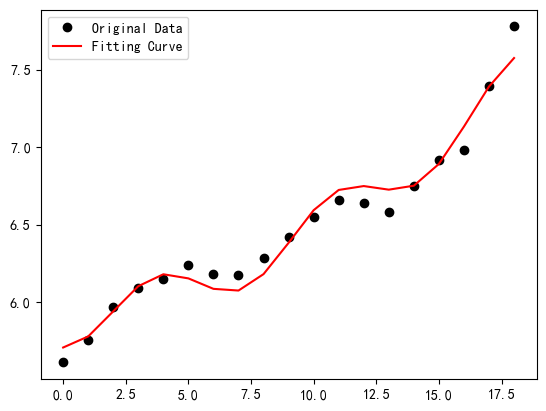

In [4]:
# 对𝜉做散点拟合（1986-2004年间），得到𝜉(t)
x = np.arange(0,19,1)
y = df11['gamma']
popt,pcov=curve_fit(lambda t,a,b,c,d,e,f: a+b*t+c*t**2+d*np.sin(e*t+f),x,y)
print('popt: ',popt)
plt.figure()
a,b,c,d,e,f=popt
y_pre = a+b*x+c*x**2+d*np.sin(e*x+f)
plt.plot(x, y, 'ko', label="Original Data")
plt.plot(x, y_pre, 'r-', label="Fitting Curve")
plt.legend()
plt.show()

The result of curve fitting for $\gamma(t)$ is:
$$\gamma(t)=5.86+3.03\times10^{-2}t+3.15\times10^{-3}t^2-1.54\times10^{-1}sin(8.87\times10^{-1}t+1.42) \tag{7}$$

In [5]:
#（7）（6’）式代入（3）（4）式后解常微分方程组
def f(t,u):
    #x1,x2...xn = u
    x,y = u
    #dx1dt=...,dx2dt=...,dxndt=...
    dxdt = -105 + 102/y*(821+(3.69+3441/86750*x-0.00000384*x**2)*(y-821))+(5.86+0.0303*t+0.00315*t**2-0.154*np.sin(0.887*t+1.42))
    dydt = 105 - 102/y*(821+(3.69+3441/86750*x-0.00000384*x**2)*(y-821))
    #dudt = [dx1dt,dx2dt,...dxndt]
    dudt = [dxdt,dydt]
    return dudt
#x1(0)=...,x2(0)=...,xn(0)=...
u0=[740,900]
t = np.linspace(0,18,19)
sol = odeint(f,u0,t,tfirst=True)

In [6]:
#单位换算为ppm,并打印1987-2004年的N1
res_buffer = []
for i in range(19):
    res_buffer.append(sol[i][0]/740*347)
res_buffer[1:19]

[385.6206105245448,
 389.1217264712141,
 391.9626696925123,
 394.8494323488009,
 397.7468394323386,
 400.618628846124,
 403.46853359849166,
 406.3399318489883,
 409.2860521926387,
 412.33296678618683,
 415.4625413448939,
 418.6280035441636,
 421.79054223497957,
 424.9500662339734,
 428.1474725163775,
 431.43668109339546,
 434.84710630031134,
 438.36415269246237]

**Ref:** The thought of the curve fitting of $\gamma(t)$ was inspired by *Jiang Xiating*, and the corresponding code was referred to *Together_CZ* (https://blog.csdn.net/together_cz/article/details/100538951). The method to handle the system of the ODE was referred to *whr804* (https://blog.csdn.net/weixin_61268973/article/details/122462611).

## 1.3

In [7]:
#将1.2结果存到df11中:
df11['bufferN1_ppm'] = 347
for i in range(19):
    df11.iloc[i,5]=res_buffer[i]

#将1.1和1.2在1986年的对应值赋值为空值,方便画图（图上没有1986年的）
df11.iloc[0,4:6]=np.nan
df11.head(3)

,Year,gamma,delta_N1,N1,N1_ppm,bufferN1_ppm
0,1986,5.609,2.609,740.000,NaN,NaN
1,1987,5.755,2.755,742.755,348.291872,385.620611
2,1988,5.968,2.968,745.723,349.683623,389.121726


In [8]:
#导入观测值，并与df11合并，再生成一个datetime列
from datetime import datetime, timedelta
from pandas import DataFrame
df2 = pd.read_csv("Loa.csv")
df22 = df2.loc[(df2['Year'] >= 1986) & (df2['Year']<2005)]
df_merge = df11.merge(df22,on='Year').rename(columns={'mean':'Observed'})
df_merge['Year']=pd.to_datetime(df_merge['Year'], format="%Y")
df_merge

,Year,gamma,delta_N1,N1,N1_ppm,bufferN1_ppm,Observed,unc
0,1986-01-01,5.609,2.609,740.000,NaN,NaN,347.61,0.12
1,1987-01-01,5.755,2.755,742.755,348.291872,385.620611,349.31,0.12
2,1988-01-01,5.968,2.968,745.723,349.683623,389.121726,351.69,0.12
3,1989-01-01,6.088,3.088,748.811,351.131645,391.962670,353.20,0.12
4,1990-01-01,6.151,3.151,751.962,352.609208,394.849432,354.45,0.12
5,1991-01-01,6.239,3.239,755.201,354.128036,397.746839,355.70,0.12
6,1992-01-01,6.178,3.178,758.379,355.618261,400.618629,356.54,0.12
7,1993-01-01,6.172,3.172,761.551,357.105672,403.468534,357.21,0.12
8,1994-01-01,6.284,3.284,764.835,358.645601,406.339932,358.96,0.12
9,1995-01-01,6.422,3.422,768.257,360.250242,409.286052,360.97,0.12


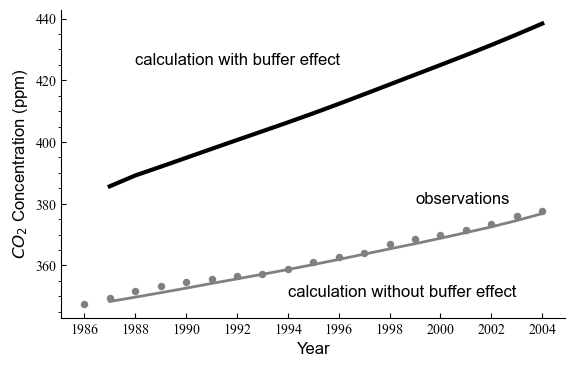

In [9]:
#画图
fig, ax = plt.subplots(figsize=(6.5,4))
plt.plot(df_merge['Year'],df_merge['N1_ppm'],lw=2,color='grey')
plt.plot(df_merge['Year'],df_merge['bufferN1_ppm'],lw=3,color='k')
plt.scatter(df_merge['Year'],df_merge['Observed'],marker='o',s=19,color='grey')
plt.xlabel("Year",fontsize=12,fontproperties="Arial")
plt.ylabel("$CO_2$ Concentration (ppm)",fontsize=12,fontproperties="Arial")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


#刻度朝里、刻度字体新罗马
plt.tick_params(labelsize=10,direction='in')
x1_label = ax.get_xticklabels() 
[x1_label_temp.set_fontname('Times New Roman') for x1_label_temp in x1_label];
y1_label = ax.get_yticklabels() 
[y1_label_temp.set_fontname('Times New Roman') for y1_label_temp in y1_label];

#y轴坐标刻度：主+次
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
yminorLocator   = MultipleLocator(5) #将y轴次刻度标签设置为n的倍数
ax.yaxis.set_minor_locator(yminorLocator)

#加上批注text
plt.text(df_merge.iloc[8,0],350,"calculation without buffer effect",fontsize=12,fontproperties="Arial");
plt.text(df_merge.iloc[13,0],380,"observations",fontsize=12,fontproperties="Arial");
plt.text(df_merge.iloc[2,0],425,"calculation with buffer effect",fontsize=12,fontproperties="Arial");

**Ref:** The details about beautifing the plot was referred to *RS&Hydrology* (https://blog.csdn.net/qq_32649321/article/details/120324133).